# Quantum Fourier Transform Benchmark

In [1]:
low = 1
high = 27
samples = 10

In [2]:
import time
import random
import math
import numpy as np

## PyQrack

In [3]:
%env QRACK_QUNITMULTI_DEVICES 1
from pyqrack import QrackSimulator, Pauli

def reverse_qrack(sim):
    start = 0
    end = sim.num_qubits() - 1
    while (start < end):
        sim.swap(start, end)
        start += 1
        end -= 1

env: QRACK_QUNITMULTI_DEVICES=1


### |0> initialization

In [4]:
def bench_qrack_0(n):
    sim = QrackSimulator(n, isOpenCL=False)
    # Permutation basis eigenstate initialization before QFT is "trivial" for Qrack.
    start = time.perf_counter()
    qubits = [i for i in range(n)]
    sim.qft(qubits)
    reverse_qrack(sim)
    sim.m_all()

    return time.perf_counter() - start

qrack_0_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qrack_0(n))

    qrack_0_results[n] = sum(width_results) / samples

print(qrack_0_results)

{1: 0.0001259538003068883, 2: 2.6194099336862565e-05, 3: 1.1022498802049085e-05, 4: 1.2670299474848434e-05, 5: 1.4500998804578558e-05, 6: 2.1379499230533838e-05, 7: 1.8893399828812108e-05, 8: 2.134620153810829e-05, 9: 2.3301101464312524e-05, 10: 2.6072501350427045e-05, 11: 3.237430064473301e-05, 12: 3.093350096605718e-05, 13: 3.3643299684626984e-05, 14: 3.660600050352514e-05, 15: 3.9064300653990355e-05, 16: 4.2470799962757154e-05, 17: 4.5542599400505425e-05, 18: 5.312750145094469e-05, 19: 6.189569903654046e-05, 20: 5.9639400569722055e-05, 21: 6.01206993451342e-05, 22: 7.355180132435634e-05, 23: 6.888580101076514e-05, 24: 7.146100033423863e-05, 25: 7.33088018023409e-05, 26: 7.728690106887371e-05, 27: 8.656760037411005e-05}


### Random 1-qubit unitary initialization

In [5]:
def bench_qrack(n):
    sim = QrackSimulator(n)
    # Permutation basis eigenstate initialization before QFT is "trivial" for Qrack,
    # so we give it a realistic case instead.
    for i in range(n):
        # Initialize with uniformly random single qubit gates, across full width.
        sim.u(i, random.uniform(0, 4 * math.pi), random.uniform(0, 4 * math.pi), random.uniform(0, 4 * math.pi))
    start = time.perf_counter()
    qubits = [i for i in range(n)]
    sim.qft(qubits)
    reverse_qrack(sim)
    sim.m_all()

    return time.perf_counter() - start

qrack_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qrack(n))

    qrack_results[n] = sum(width_results) / samples

print(qrack_results)

Device #0, Loaded binary from: /home/iamu/.qrack/qrack_ocl_dev_Intel(R)_UHD_Graphics_[0x9bc4].ir
Device #1, Loaded binary from: /home/iamu/.qrack/qrack_ocl_dev_NVIDIA_GeForce_RTX_3080_Laptop_GPU.ir
{1: 7.255301170516759e-06, 2: 8.966710011009127e-05, 3: 0.00019343699896126054, 4: 0.00023128509928938001, 5: 0.0002245663992653135, 6: 0.00036489439953584223, 7: 0.00038095290001365355, 8: 0.0004755372014187742, 9: 0.0006721817990182899, 10: 0.0008079267994617112, 11: 0.0015157900998019613, 12: 0.001897978199122008, 13: 0.0027178260999789925, 14: 0.0029240778989333195, 15: 0.0032650328997988255, 16: 0.003787877599825151, 17: 0.004098802799853729, 18: 0.00488780880041304, 19: 0.005692177501623518, 20: 0.00900803039985476, 21: 0.010699154500616714, 22: 0.01797617950142012, 23: 0.029683881299570204, 24: 0.05517430260006222, 25: 0.09676741429939284, 26: 0.1840585525991628, 27: 0.3697666353997192}


### GHZ state initialization

In [6]:
def bench_qrack(n):
    sim = QrackSimulator(n)
    sim.h(0)
    for i in range(n - 1):
        sim.mcx([i], i + 1)
    start = time.perf_counter()
    qubits = [i for i in range(n)]
    sim.qft(qubits)
    reverse_qrack(sim)
    sim.m_all()

    return time.perf_counter() - start

qrack_k_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qrack(n))

    qrack_k_results[n] = sum(width_results) / samples

print(qrack_k_results)

{1: 4.0978199103847145e-05, 2: 5.308160107233562e-05, 3: 0.0001863782999862451, 4: 0.0004263114999048412, 5: 0.0005706420008209534, 6: 0.0008252390027337242, 7: 0.0012933823985804339, 8: 0.0020267858992156105, 9: 0.003502880899759475, 10: 0.006029934000252979, 11: 0.012698578202252975, 12: 0.014658257400151342, 13: 0.015474617801373824, 14: 0.01703828940007952, 15: 0.019342201000108618, 16: 0.02215594070221414, 17: 0.02918995159852784, 18: 0.032294207100494535, 19: 0.03674265470035607, 20: 0.03952980419999221, 21: 0.05369433880186989, 22: 0.0682977303986263, 23: 0.10617154249994201, 24: 0.16436891030098194, 25: 0.2938959849991079, 26: 0.5459271662017272, 27: 1.056282505899435}


## FFTW ("Classical" DFT)

In [7]:
# See https://blog.hpc.qmul.ac.uk/pyfftw.html
import pyfftw

pyfftw.interfaces.cache.enable()
pyfftw.interfaces.cache.set_keepalive_time(60)
total_time = 0

### |0> initialization

In [8]:
fftw_0_results = {}
for n in range(low, high + 1):
    width_results = []
    for i in range(samples):
        io_array = pyfftw.empty_aligned(2**n, dtype=np.complex64)
        io_array[0] = 1.
        start = time.perf_counter()
        pyfftw.interfaces.numpy_fft.fft(io_array, overwrite_input=True, threads = (16 if (n > 19) else 1))
        width_results.append(time.perf_counter() - start)

    fftw_0_results[n] = sum(width_results) / samples

print(fftw_0_results)

{1: 4.811219987459481e-05, 2: 3.730820099008269e-05, 3: 2.7288600540487097e-05, 4: 4.0652100869920106e-05, 5: 3.275340059190057e-05, 6: 4.016890015918761e-05, 7: 2.3494201013818383e-05, 8: 2.0811099966522305e-05, 9: 2.1665500389644877e-05, 10: 2.1839099645148963e-05, 11: 2.5586700212443246e-05, 12: 8.610239892732352e-05, 13: 6.0098401445429775e-05, 14: 0.00010331709927413613, 15: 0.00019856779908877797, 16: 0.0004160727003181819, 17: 0.0008383628002775368, 18: 0.001979257000493817, 19: 0.007243700399703812, 20: 0.04508926639828133, 21: 0.04507447890064213, 22: 0.06178567819806631, 23: 0.09204879329772667, 24: 0.14838527240062832, 25: 0.25810385970107746, 26: 0.49931204300082754, 27: 1.019850606401451}


### Random 1-qubit unitary initialization

In [9]:
fftw_results = {}
for n in range(low, high + 1):
    width_results = []
    for i in range(samples):
        io_array = pyfftw.empty_aligned(2**n, dtype=np.complex64)
        
        # Use Qrack to initialize the test case!
        sim = QrackSimulator(n)
        for i in range(n):
            # Initialize with uniformly random single qubit gates, across full width.
            sim.u(i, random.uniform(0, 4 * math.pi), random.uniform(0, 4 * math.pi), random.uniform(0, 4 * math.pi))
        ket = sim.out_ket()
        del sim
        for i in range(2**n):
            io_array[i] = ket[i]
        del ket
        
        start = time.perf_counter()
        pyfftw.interfaces.numpy_fft.fft(io_array, overwrite_input=True, threads = (16 if (n > 19) else 1))
        width_results.append(time.perf_counter() - start)

    fftw_results[n] = sum(width_results) / samples

print(fftw_results)

{1: 3.476659912848845e-05, 2: 2.66197974269744e-05, 3: 2.6210500800516455e-05, 4: 2.6263200561515986e-05, 5: 2.5463500060141085e-05, 6: 2.6862500817514956e-05, 7: 2.7784100529970603e-05, 8: 2.8729400219162927e-05, 9: 2.8736299282172694e-05, 10: 3.110700054094195e-05, 11: 3.6305501271272075e-05, 12: 4.417489981278777e-05, 13: 7.286780019057914e-05, 14: 0.00010360359883634373, 15: 0.00020112490019528196, 16: 0.0004404378996696323, 17: 0.0009345197009679396, 18: 0.002134785998350708, 19: 0.008064898799057118, 20: 0.035733333101961764, 21: 0.03817898759953096, 22: 0.06230174930024077, 23: 0.11647265249994235, 24: 0.21382899019808974, 25: 0.39318087579958955, 26: 0.9440640458989946, 27: 2.122314866499073}


### GHZ initialization

In [10]:
fftw_k_results = {}
for n in range(low, high + 1):
    width_results = []
    for i in range(samples):
        io_array = pyfftw.empty_aligned(2**n, dtype=np.complex64)
        io_array[0] = 1 / math.sqrt(2)
        io_array[2**n - 1] = 1 / math.sqrt(2)
        start = time.perf_counter()
        pyfftw.interfaces.numpy_fft.fft(io_array, overwrite_input=True, threads = (16 if (n > 19) else 1))
        width_results.append(time.perf_counter() - start)

    fftw_k_results[n] = sum(width_results) / samples

print(fftw_k_results)

{1: 4.931109942845069e-05, 2: 3.165390007779934e-05, 3: 4.2846000724239275e-05, 4: 2.931609924416989e-05, 5: 1.924009920912795e-05, 6: 5.029550011386164e-05, 7: 1.8657900363905354e-05, 8: 1.9606399291660637e-05, 9: 1.826370062190108e-05, 10: 4.2104299063794314e-05, 11: 9.430340069229714e-05, 12: 3.4861299354815856e-05, 13: 0.00015299270089599303, 14: 8.979570120573043e-05, 15: 0.00017865449990495108, 16: 0.0003463868015387561, 17: 0.0008620079002866987, 18: 0.0018982736990437842, 19: 0.007590904899552697, 20: 0.04445771870159661, 21: 0.051099348200659735, 22: 0.06375993320034468, 23: 0.09140740770017146, 24: 0.14535723340086407, 25: 0.2562623840007291, 26: 0.5027156977994309, 27: 0.9575109543999133}


## Qiskit Aer

In [11]:
from qiskit import QuantumCircuit
from qiskit import execute, Aer
from qiskit.providers.aer import QasmSimulator

def reverse_aer(num_qubits, circ):
    start = 0
    end = num_qubits - 1
    while (start < end):
        circ.swap(start, end)
        start += 1
        end -= 1

# Implementation of the Quantum Fourier Transform
def aer_qft(num_qubits, circ):
    # Quantum Fourier Transform
    for j in range(num_qubits):
        for k in range(j):
            circ.cp(math.pi/float(2**(j-k)), j, k)
        circ.h(j)
    reverse_aer(num_qubits, circ)
    for j in range(num_qubits):
        circ.measure(j, j)

    return circ

sim_backend = QasmSimulator(shots=1, method='statevector_gpu')

def bench_aer(num_qubits):
    circ = QuantumCircuit(num_qubits, num_qubits)
    aer_qft(num_qubits, circ)
    start = time.perf_counter()
    job = execute([circ], sim_backend, timeout=600)
    result = job.result()
    return time.perf_counter() - start

aer_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_aer(n))

    aer_results[n] = sum(width_results) / samples

print(aer_results)

{1: 0.0040408134991594125, 2: 0.0038083241990534587, 3: 0.004935220301558729, 4: 0.005604743998264894, 5: 0.006579184300062479, 6: 0.007555933899857337, 7: 0.008309486999496584, 8: 0.009329735798382898, 9: 0.010083982400828972, 10: 0.010913049599912484, 11: 0.012050660300155868, 12: 0.013044205598998816, 13: 0.016800459399382815, 14: 0.015445972799352604, 15: 0.018070685901329854, 16: 0.019212737597990782, 17: 0.02037458819904714, 18: 0.022498083700338612, 19: 0.026476954000099796, 20: 0.03264390430122148, 21: 0.04779343769987463, 22: 0.06718772280000848, 23: 0.11073179749946575, 24: 0.20799590879978497, 25: 0.41458723860050667, 26: 0.8483949067012873, 27: 1.750229026600573}


## Qulacs

In [12]:
import qulacs

def reverse_qulacs(num_qubits, circ):
    start = 0
    end = num_qubits - 1
    while (start < end):
        circ.add_gate(qulacs.gate.SWAP(start, end))
        start += 1
        end -= 1

def get_rotz(exponent: float) -> np.ndarray:
    return np.diag([1., np.exp(1.j * np.pi * exponent)])

def bench_qulacs(n):
    sim = qulacs.QuantumStateGpu(n)
    circ = qulacs.QuantumCircuit(n)
    start = time.perf_counter()

    for j in range(n):
        for k in range(j):
            mat = get_rotz(math.pi/float(2**(j-k)))
            gate = qulacs.gate.DenseMatrix(k, mat)
            gate.add_control_qubit(j, 1)
            circ.add_gate(gate)
        circ.add_gate(qulacs.gate.H(j))
    reverse_qulacs(n, circ)
    for index in range(n):
        circ.add_gate(qulacs.gate.Measurement(index, index))

    circ.update_quantum_state(sim)

    return time.perf_counter() - start

qulacs_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qulacs(n))

    qulacs_results[n] = sum(width_results) / samples

print(qulacs_results)

{1: 0.00026662400050554426, 2: 0.0003461417007201817, 3: 0.0005004820981412194, 4: 0.0008263969000836368, 5: 0.0009973871005058755, 6: 0.0012388369985274039, 7: 0.0016485457999806385, 8: 0.0016231905996392016, 9: 0.0019415545000811107, 10: 0.0022212564006622417, 11: 0.002691702298761811, 12: 0.0032888795984035825, 13: 0.003536625399283366, 14: 0.004138559999410063, 15: 0.004223826099769212, 16: 0.007239833600760903, 17: 0.011244605699903331, 18: 0.015157984100369504, 19: 0.02556142099929275, 20: 0.046818170699407344, 21: 0.09315537419970496, 22: 0.18118212420013152, 23: 0.35784866890026024, 24: 0.6983572639997874, 25: 1.4196050380000087, 26: 2.9543034671005444, 27: 6.023129582601541}


## QCGPU

In [13]:
%env PYOPENCL_CTX 1

env: PYOPENCL_CTX=1


In [14]:
import qcgpu

def swap_qcgpu(circ, q1, q2):
    circ.cx(q1, q2)
    circ.cx(q2, q1)
    circ.cx(q1, q2)
    
def reverse_qcgpu(num_qubits, circ):
    start = 0
    end = num_qubits - 1
    while (start < end):
        swap_qcgpu(circ, start, end)
        start += 1
        end -= 1

def bench_qcgpu(num_qubits):
    state = qcgpu.State(num_qubits)
    start = time.perf_counter()
 
    for j in range(num_qubits):
        for k in range(j):
            state.cu1(j, k, math.pi/float(2**(j-k)))
        state.h(j)
    reverse_qcgpu(num_qubits, state)
    state.measure()

    state.backend.queue.finish()
    return time.perf_counter() - start

qcgpu_results = {}
for n in range(low, high + 1):
    width_results = []
         
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qcgpu(n))

    qcgpu_results[n] = sum(width_results) / samples

print(qcgpu_results)

{1: 0.0012106278001738247, 2: 0.0025262652001401876, 3: 0.0026878743010456674, 4: 0.004331886699219467, 5: 0.005561603099340573, 6: 0.007048522600962314, 7: 0.007929704999696696, 8: 0.009564954199595377, 9: 0.010942662500747246, 10: 0.01288679899953422, 11: 0.015474901200650492, 12: 0.018708950399013703, 13: 0.02157499760069186, 14: 0.024808585501159542, 15: 0.028259393098414874, 16: 0.03201712580048479, 17: 0.036060876700503286, 18: 0.04600565750079113, 19: 0.049080436500662475, 20: 0.058835771399753864, 21: 0.076249901700794, 22: 0.1037423787987791, 23: 0.17294347349961753, 24: 0.3550135568002588, 25: 0.7229957103976631, 26: 1.5119469584009493, 27: 3.1266679840002327}


## Results

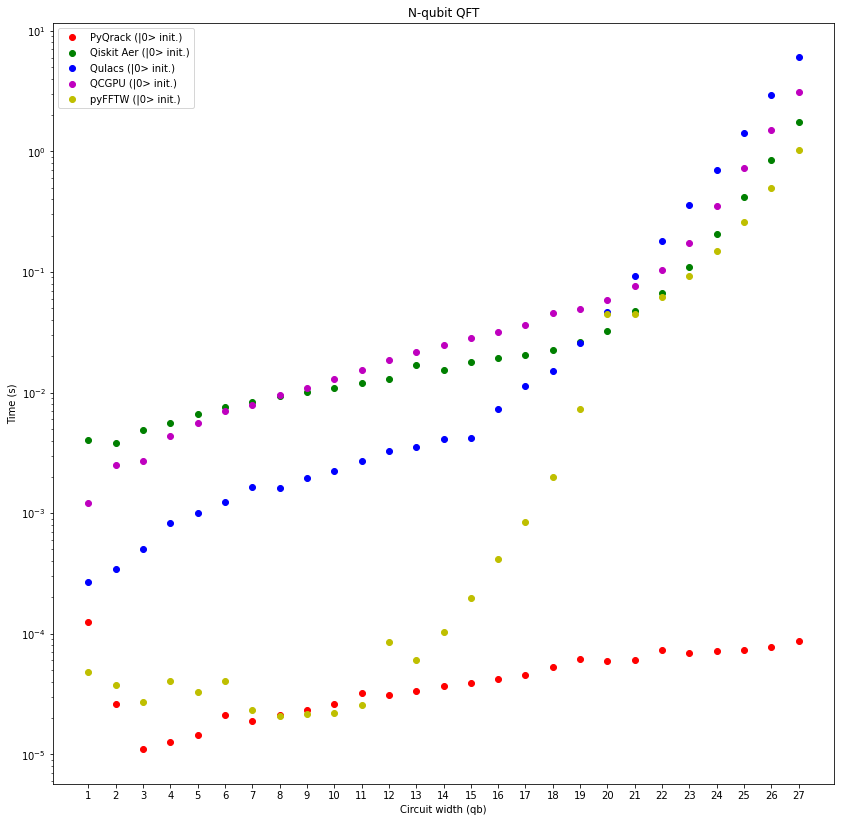

In [15]:
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(14, 14)

colors = list("kcymbgr")

x = qrack_0_results.keys()
y = qrack_0_results.values()
plt.scatter(x,y,color=colors.pop())

x = aer_results.keys()
y = aer_results.values()
plt.scatter(x,y,color=colors.pop())

x = qulacs_results.keys()
y = qulacs_results.values()
plt.scatter(x,y,color=colors.pop())

x = qcgpu_results.keys()
y = qcgpu_results.values()
plt.scatter(x,y,color=colors.pop())

x = fftw_0_results.keys()
y = fftw_0_results.values()
plt.scatter(x,y,color=colors.pop())

plt.title("N-qubit QFT")
plt.xlabel("Circuit width (qb)")
plt.ylabel("Time (s)")
plt.legend(["PyQrack (|0> init.)", "Qiskit Aer (|0> init.)", "Qulacs (|0> init.)", "QCGPU (|0> init.)", "pyFFTW (|0> init.)"])
plt.yscale("log")
plt.xticks(np.arange(low, high + 1, step=1))

plt.show()

fig.savefig('qft_0_chart.png', dpi=100)

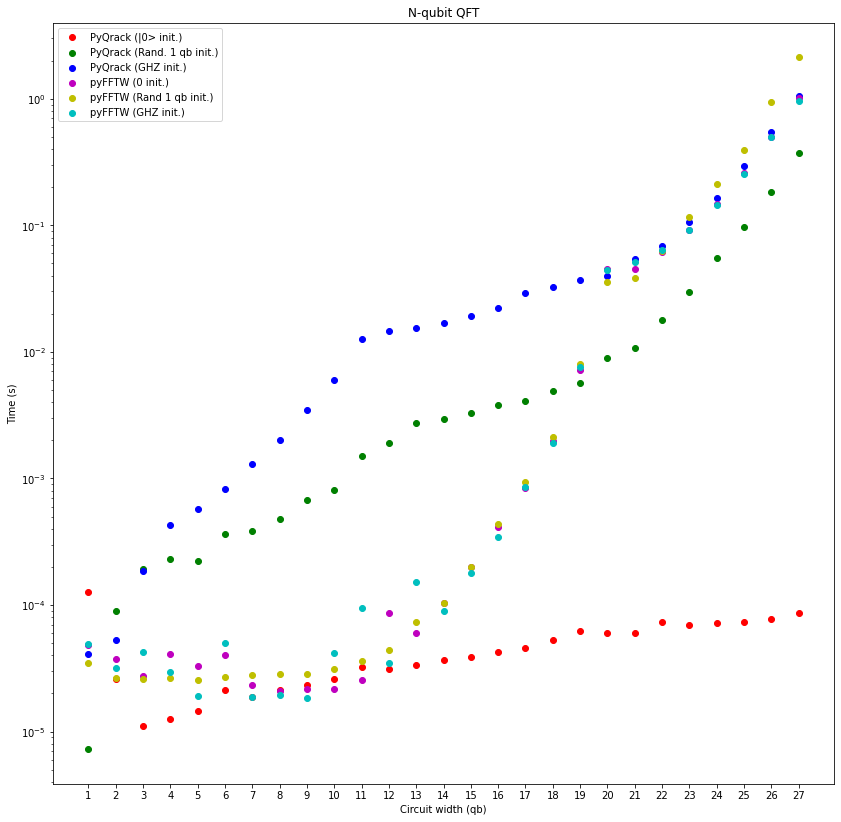

In [16]:
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(14, 14)

colors = list("cymbgr")

x = qrack_0_results.keys()
y = qrack_0_results.values()
plt.scatter(x,y,color=colors.pop())

x = qrack_results.keys()
y = qrack_results.values()
plt.scatter(x,y,color=colors.pop())

x = qrack_k_results.keys()
y = qrack_k_results.values()
plt.scatter(x,y,color=colors.pop())

x = fftw_0_results.keys()
y = fftw_0_results.values()
plt.scatter(x,y,color=colors.pop())

x = fftw_results.keys()
y = fftw_results.values()
plt.scatter(x,y,color=colors.pop())

x = fftw_k_results.keys()
y = fftw_k_results.values()
plt.scatter(x,y,color=colors.pop())

plt.title("N-qubit QFT")
plt.xlabel("Circuit width (qb)")
plt.ylabel("Time (s)")
plt.legend(["PyQrack (|0> init.)", "PyQrack (Rand. 1 qb init.)", "PyQrack (GHZ init.)", "pyFFTW (0 init.)", "pyFFTW (Rand 1 qb init.)", "pyFFTW (GHZ init.)"])
plt.yscale("log")
plt.xticks(np.arange(low, high + 1, step=1))

plt.show()

fig.savefig('qft_ghz_chart.png', dpi=100)

In [17]:
import platform

print(platform.machine())
print(platform.version())
print(platform.platform())
print(platform.uname())
print(platform.system())
print(platform.processor())

x86_64
#33~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Mon Jan 30 17:03:34 UTC 2
Linux-5.19.0-32-generic-x86_64-with-glibc2.35
uname_result(system='Linux', node='sekhmet', release='5.19.0-32-generic', version='#33~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Mon Jan 30 17:03:34 UTC 2', machine='x86_64')
Linux
x86_64


In [18]:
import subprocess

line_as_bytes = subprocess.check_output("nvidia-smi -L", shell=True)
line = line_as_bytes.decode("ascii")
_, line = line.split(":", 1)
line, _ = line.split("(")
print(line.strip())

NVIDIA GeForce RTX 3080 Laptop GPU


In [19]:
import cpuinfo
cpuinfo.get_cpu_info()['brand_raw']

'Intel(R) Core(TM) i9-10980HK CPU @ 2.40GHz'